# Bibliografía
- https://poloclub.github.io/cnn-explainer/ - CNN explainer
- https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch - Modelo CNN de ejemplo
- Modelo preentrenado



# Autenticación de huellas (Biometría) - CNN
En esta hipótesis planteamos resolver el problema de autenticar un conjunto de huellas conocidas mediante una red neuronal convolucional (CNN), la cual puede aprender y extraer características relevantes directamente de las imágenes, analizando estructuras únicas como crestas y patrones para diferenciarlas y clasificarlas eficientemente. Durante el entrenamiento, se utilizarán imágenes de huellas autenticadas y rechazadas, permitiendo que la red ajuste sus parámetros para minimizar errores, y finalmente el modelo entrenado se aplicará a nuevas huellas para predecir si pertenecen a un usuario autenticado, evaluando su rendimiento con métricas como precisión, tasa de falsos positivos y falsos negativos.

### Importación de librerías utilizadas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import shutil
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from sklearn.metrics import f1_score, roc_curve, auc, det_curve


### Prepocesamiento de las imágenes de las huellas
1. Recorte: Se localiza el contorno más grande en cada imagen, que corresponde a la huella, y se recorta para eliminar bordes innecesarios y centrarse en las áreas importantes, permitiendo trabajar con imágenes uniformes del mismo tamaño.

2. Filtrado: Para mejorar la calidad de las huellas y resaltar sus detalles clave, se aplicaron varias técnicas:
    - Ecualización con CLAHE para mejorar el contraste en áreas oscuras.
    - Filtro bilateral para suavizar sin perder bordes importantes.
    - Filtro de mediana para eliminar ruido sin degradar líneas finas.
    - Binarización adaptativa para segmentar crestas y valles bajo distintas condiciones de iluminación.
    - Limpieza morfológica para eliminar artefactos de ruido.
    - Esqueletonizado para reducir la huella a su estructura básica y facilitar el análisis.

In [ ]:
def recortar_imagen(input_folder, output_folder, crop_width=550, crop_height=550, threshold_value=225):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if not file.endswith(('.png', '.jpg', '.jpeg')): 
                continue

            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Error al leer la imagen {img_path}")
                continue

            # Binarización de la imagen
            _, thresh = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)

            # Encontramos los contornos
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Seleccionamos el contorno más grande
                largest_contour = max(contours, key=cv2.contourArea)

                # Calcula el rectángulo para el contorno
                x, y, w, h = cv2.boundingRect(largest_contour)

                center_x, center_y = x + w // 2, y + h // 2

                # Coordenadas para recortar la imagen
                x_start = max(center_x - crop_width // 2, 0)
                y_start = max(center_y - crop_height // 2, 0)
                x_end = min(center_x + crop_width // 2, img.shape[1])
                y_end = min(center_y + crop_height // 2, img.shape[0])

                if (x_end - x_start) != crop_width:
                    x_start = max(0, x_end - crop_width)
                if (y_end - y_start) != crop_height:
                    y_start = max(0, y_end - crop_height)

                # Recorte
                cropped_img = img[y_start:y_end, x_start:x_end]

                output_path = os.path.join(output_folder, file)
                cv2.imwrite(output_path, cropped_img)
                print(f"Imagen recortada guardada en {output_path}")

input_folder = 'imagenes_huellas'   
output_folder = 'imagenes_recortadas' 

recortar_imagen(input_folder, output_folder)

img = cv2.imread('imagenes_recortadas/11f_01.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
def procesar_imagen(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}.")
        return
    
    # Ecualización de histograma local con CLAHE para mejorar el contraste
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    # Filtrado bilateral para suavizar la imagen y quedarnos con los bordes
    bilateral_filtered = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Filtrado de mediana para eliminar ruido
    median_filtered = cv2.medianBlur(bilateral_filtered, 3)
    
    # Binarización para quedarnos con las crestas y valles de la huella
    thresh_image = cv2.adaptiveThreshold(
        median_filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        19,
        3
    )
    
    # Invierte la imagen binaria
    inverted_image = cv2.bitwise_not(thresh_image)
    
    # Elimina pequeños puntos blancos
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    
    # Esqueletonización para reducir la huella a líneas de un píxel
    skeleton = np.zeros(cleaned_image.shape, np.uint8)
    img = cleaned_image.copy()
    while True:
        eroded = cv2.erode(img, None)  
        temp = cv2.dilate(eroded, None)  
        temp = cv2.subtract(img, temp) 
        skeleton = cv2.bitwise_or(skeleton, temp)  
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:  
            break

    cv2.imwrite(output_path, skeleton)
    print(f"Imagen procesada y guardada en {output_path}")



input_dir = 'imagenes_recortadas'  
output_dir = 'imagenes_filtradas' 

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.png'):  
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_dir, file)
            
            procesar_imagen(image_path, output_path)
          

img = cv2.imread('imagenes_filtradas/11f_01.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()


### Estrucutra de datos para el entrenamiento

Creamos nuestra base de datos para entrenar el modelo, organizando las imágenes procesadas en carpetas separadas para entrenamiento y prueba, con subcarpetas que etiquetan las imágenes como autenticadas o rechazadas. Las imágenes de entrenamiento se seleccionan a partir de aquellas que contienen la letra 'f' en su nombre, mientras que las de prueba se eligen entre las que tienen la letra 's'. Cada conjunto se divide en dos partes: la primera mitad se clasifica como autenticada y la segunda como rechazada, copiando los archivos correspondientes a sus respectivas carpetas (train/authenticated, train/rejected, test/authenticated y test/rejected).

In [ ]:
input_dir = 'imagenes_filtradas'

output_dir = 'data'
os.makedirs(os.path.join(output_dir, 'train/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/rejected'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/rejected'), exist_ok=True)

train_images = [img for img in os.listdir(input_dir) if 'f' in img]
test_images = [img for img in os.listdir(input_dir) if 's' in img]

# Etiqueta como autenticadas o rechazadas
for idx, image in enumerate(train_images):
    if idx < len(train_images) // 2:  
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train/authenticated', image))
    else:  
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train/rejected', image))

for idx, image in enumerate(test_images):
    if idx < len(test_images) // 2: 
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test/authenticated', image))
    else: 
        shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test/rejected', image))

print("Estructura creada con éxito.")


### Data augmentation
Realizamos data augmentation para generar un número determinado de variaciones aleatorias por imagen, aplicando transformaciones como rotación, escalado, traslación y corte parcial en imágenes rechazadas. Las nuevas imágenes se guardan en sus respectivas carpetas de entrenamiento y prueba, aumentando la cantidad y diversidad del conjunto de datos para mejorar el rendimiento del modelo.

In [ ]:
def new_images(input_dir, num_images):
    images = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(input_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            img_copy = img.copy()
            
            # Rotación aleatoria
            angle = random.randint(-90, 90)
            h, w = img_copy.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_img = cv2.warpAffine(img_copy, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Escalado aleatorio
            scale_x = random.uniform(0.5, 1.2)
            scale_y = random.uniform(0.5, 1.2)
            augmented_img = cv2.resize(augmented_img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            
            if input_dir.endswith('rejected'):
            # Corte parcial (simulando mal contacto)
                x1, y1 = random.randint(0, w // 8), random.randint(0, h // 8)
                x2, y2 = random.randint(x1, w // 4), random.randint(y1, h // 4)
                cv2.rectangle(augmented_img, (x1, y1), (x2, y2), (0, 0, 0), -1)
                
            # Traslación aleatoria
            max_shift = 10  
            tx = random.randint(-max_shift, max_shift)
            ty = random.randint(-max_shift, max_shift)
            translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
            augmented_img = cv2.warpAffine(augmented_img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            output_name = f"{i}_{image_name}"
            cv2.imwrite(os.path.join(input_dir, output_name), augmented_img)


train_authenticated_dir = 'data/train/authenticated'
test_authenticated_dir = 'data/test/authenticated'
train_rejected_dir = 'data/train/rejected'
test_rejected_dir = 'data/test/rejected'

for directory in [train_authenticated_dir, test_authenticated_dir, train_rejected_dir, test_rejected_dir]:
        new_images(directory, num_images=20)


### Etiquetamos las huellas
Implementamos un dataset personalizado y transformaciones para preparar las imágenes de entrenamiento y prueba, aplicando data augmentation dinámico al conjunto de entrenamiento para aumentar su diversidad. Las transformaciones incluyen rotación, volteo horizontal y vertical, traslación, distorsión de perspectiva y normalización, asegurando que las imágenes se redimensionen a 224x224 y se conviertan en tensores. Las imágenes se etiquetan automáticamente como 0 (autenticadas) o 1 (rechazadas) según su subcarpeta correspondiente.

Posteriormente, utilizamos DataLoaders para cargar los datasets de entrenamiento y prueba en lotes de tamaño 16, permitiendo la iteración eficiente sobre las imágenes y sus etiquetas para alimentar la red neuronal. Finalmente, se verifican las dimensiones y etiquetas de un lote del conjunto de entrenamiento.

In [ ]:
# Transformaciones para el entrenamiento (con data augmentation dinámico)
train_transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.Resize((224, 224)),  
    transforms.RandomRotation(degrees=360),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.RandomPerspective(distortion_scale=0.2, p=0.25),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

test_transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])


# Clase para cargar el dataset
class FingerprintDataset(Dataset):
    def __init__(self, directory, transform):
        self.transform = transform
        self.data = []

        for label, subfolder in enumerate(['authenticated', 'rejected']):
            subfolder_path = os.path.join(directory, subfolder)
            if os.path.exists(subfolder_path):  
                for img_name in os.listdir(subfolder_path):
                    if img_name.endswith('.png'):
                        img_path = os.path.join(subfolder_path, img_name)
                        self.data.append((img_path, label)) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        return image, label


train_dataset = FingerprintDataset(directory='data/train', transform=train_transform)
test_dataset = FingerprintDataset(directory='data/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for images, labels in train_loader:
    print(images.shape) 
    print(labels)  # Etiquetas: 0 (autenticadas), 1 (rechazadas)
    break  


### Modelo CNN
Definimos una red neuronal convolucional (CNN) para la autenticación de huellas dactilares. El modelo consta de cuatro capas convolucionales con funciones de activación LeakyReLU para evitar el problema de la "Dying ReLU", normalización mediante BatchNorm y reducción de tamaño con MaxPooling, lo que permite extraer características importantes de las imágenes. Tras las convoluciones, el tamaño del tensor se calcula automáticamente con una entrada ficticia para evitar errores dimensionales.

La salida convolucional se aplana y pasa por tres capas completamente conectadas (FC) con activaciones LeakyReLU, normalización, Dropout para evitar el sobreajuste y una capa de salida con activación Sigmoid, que devuelve una probabilidad entre 0 y 1 para clasificar las imágenes en autenticadas o rechazadas.

In [ ]:
class FingerprintCNN(nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        # Calcula el tamaño del tensor después de las convoluciones para evitar errores de tamaño
        self._calculate_flatten_size()
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(self.flattened_size, 512),  
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.5), 
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.5),  
            
            nn.Linear(256, 1),  # Una salida binaria
            nn.Sigmoid()  # Activación entre 0 y 1
        )
    
    def _calculate_flatten_size(self):
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 224, 224)  # Tamaño de entrada esperado
                conv_out = self.conv_layers(dummy_input)
                self.flattened_size = conv_out.numel()  # Calcula el tamaño después de las convoluciones
        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

model = FingerprintCNN().to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

### Entrenamiento
Definimos el proceso de entrenamiento del modelo CNN para la autenticación de huellas dactilares, donde se ejecutan las diferentes épocas en las que el modelo realiza ajustes iterativos de sus parámetros. En cada iteración, el modelo realiza un forward pass para predecir las etiquetas de las imágenes de entrada y calcular la pérdida utilizando la función de costo definida, es entonces cuando se realiza el backward pass, donde se reinician los gradientes, y se calculan las derivadas de la pérdida respecto a los parámetros y se actualizan los pesos mediante el optimizador.

In [123]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        
        
        outputs = model(images).squeeze(1)  # Eliminamos la dimensión extra de la salida
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 0.4672
Epoch 2/100, Loss: 0.3342
Epoch 3/100, Loss: 0.4245
Epoch 4/100, Loss: 0.3638
Epoch 5/100, Loss: 0.4765
Epoch 6/100, Loss: 0.4335
Epoch 7/100, Loss: 0.3723
Epoch 8/100, Loss: 0.3200
Epoch 9/100, Loss: 0.4103
Epoch 10/100, Loss: 0.3913
Epoch 11/100, Loss: 0.3648
Epoch 12/100, Loss: 0.3860
Epoch 13/100, Loss: 0.3712
Epoch 14/100, Loss: 0.4861
Epoch 15/100, Loss: 0.3406
Epoch 16/100, Loss: 0.4458
Epoch 17/100, Loss: 0.4998
Epoch 18/100, Loss: 0.4459
Epoch 19/100, Loss: 0.4052
Epoch 20/100, Loss: 0.3630
Epoch 21/100, Loss: 0.4490
Epoch 22/100, Loss: 0.4697
Epoch 23/100, Loss: 0.4124
Epoch 24/100, Loss: 0.4602
Epoch 25/100, Loss: 0.3629
Epoch 26/100, Loss: 0.3059
Epoch 27/100, Loss: 0.2972
Epoch 28/100, Loss: 0.4177
Epoch 29/100, Loss: 0.4692
Epoch 30/100, Loss: 0.4486
Epoch 31/100, Loss: 0.2758
Epoch 32/100, Loss: 0.3411
Epoch 33/100, Loss: 0.4329
Epoch 34/100, Loss: 0.3249
Epoch 35/100, Loss: 0.4208
Epoch 36/100, Loss: 0.3149
Epoch 37/100, Loss: 0.2981
Epoch 38/1

### Guardado del modelo

In [125]:
torch.save(model, 'FingerprintCNN.pth')

### Evaluación
En la fase de evaluación, el modelo predice etiquetas en el conjunto de prueba utilizando un umbral de decisión y se calculan métricas como accuracy y F1-score. Se generan las curvas ROC y DET, destacando el EER (Equal Error Rate) como punto clave donde las tasas de falsos positivos y falsos negativos son iguales, además se grafica la densidad de probabilidad de las predicciones para analizar la separación entre clases autenticadas y rechazadas, evaluando así el rendimiento general del modelo.

F1-Score: 0.2362
Accuracy en conjunto de prueba: 53.81%
Total de imágenes: 210, Correctas: 113, Incorrectas: 97


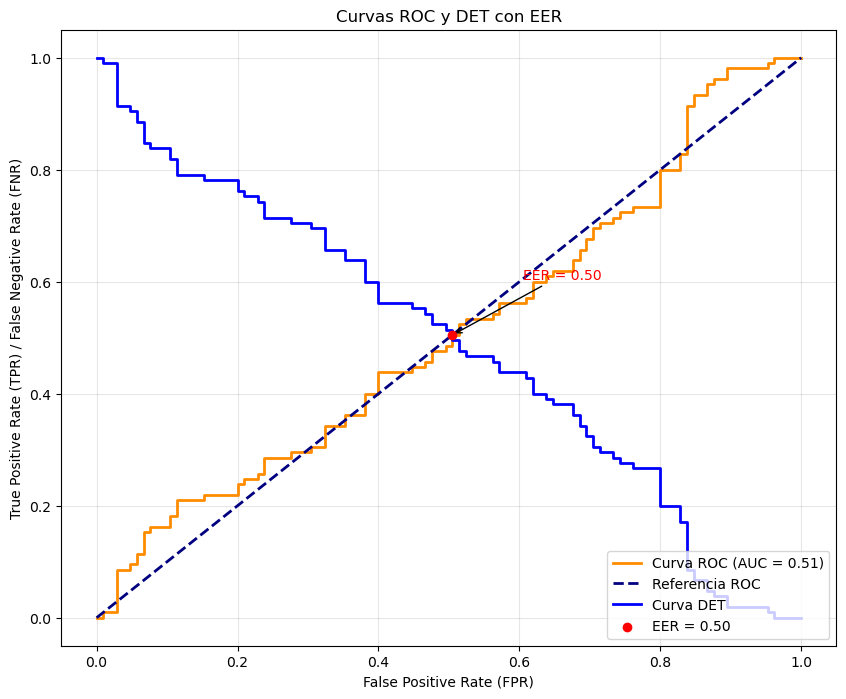

C:\Users\Acer\AppData\Local\Temp\ipykernel_15624\1340208071.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(probabilities)[np.array(labels) == 1], label='Autenticadas (1)', shade=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_15624\1340208071.py:75: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(probabilities)[np.array(labels) == 0], label='Rechazadas (0)', shade=True)


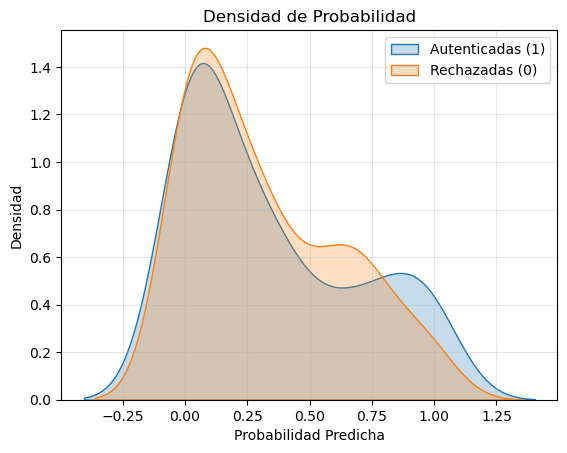

In [124]:
# Cargamos el modelo 
#model = torch.load('FingerprintCNN.pth')
#model.to(device)  


model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.85).float()  # Umbral: salida > 0.85 es 1 (authenticated)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(outputs.cpu().numpy())

# F1-score
f1 = f1_score(all_labels, all_predictions)
print(f"F1-Score: {f1:.4f}")

accuracy = 100 * correct / total
print(f"Accuracy en conjunto de prueba: {accuracy:.2f}%")
print(f"Total de imágenes: {total}, Correctas: {correct}, Incorrectas: {total - correct}")

# Curva ROC y EER
def calculate_metrics(labels, probabilities):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
    return fpr, tpr, fnr, roc_auc, eer, eer_threshold

fpr, tpr, fnr, roc_auc, eer, eer_threshold = calculate_metrics(all_labels, all_probabilities)



def plot_curves(fpr, tpr, fnr, roc_auc, eer):
    plt.figure(figsize=(10, 8))

    # ROC Curve
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Referencia ROC')

    # DET Curve
    plt.plot(fpr, fnr, label='Curva DET', color='blue', lw=2)

    # EER Annotation
    plt.scatter([eer], [eer], color='red', zorder=5, label=f'EER = {eer:.2f}')
    plt.annotate(f"EER = {eer:.2f}", xy=(eer, eer), xytext=(eer + 0.1, eer + 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='red')

    plt.title('Curvas ROC y DET con EER')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / False Negative Rate (FNR)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_curves(fpr, tpr, fnr, roc_auc, eer)


# Función de densidad de probabilidad
def plot_probability_density(labels, probabilities):
    sns.kdeplot(np.array(probabilities)[np.array(labels) == 1], label='Autenticadas (1)', shade=True)
    sns.kdeplot(np.array(probabilities)[np.array(labels) == 0], label='Rechazadas (0)', shade=True)
    plt.title('Densidad de Probabilidad')
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_probability_density(all_labels, all_probabilities)


### Visualización de predicciones
Se muestran las imágenes de un lote junto a sus etiquetas reales y predichas usando un umbral de 0.85, facilitando la comparación visual y numérica de los resultados.

In [ ]:
model.eval()

images, labels = next(iter(train_loader)) 
images, labels = images.to(device), labels.to(device)

# Realiza las predicciones
with torch.no_grad():  
    outputs = model(images).squeeze(1) 
    predictions = (outputs >= 0.85).float()  # Clasifica como 1 si probabilidad >= 0.85, de lo contrario 0

# Visualiza las imágenes con sus etiquetas reales y predichas
fig, axes = plt.subplots(1, 8, figsize=(16, 8))
for i, ax in enumerate(axes):
    img = images[i].cpu().squeeze().numpy()  
    real_label = labels[i].item()
    predicted_label = predictions[i].item()  
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {real_label}, Pred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Etiquetas reales: ", labels.cpu().numpy())
print("Etiquetas predichas: ", predictions.cpu().numpy())


In [ ]:
# Clasifica una nueva huella
def classify_fingerprint(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('L')  
    image = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(image).item()
    return "Authenticated" if output > 0.85 else "Rejected"

# Ruta de la nueva huella
new_fingerprint_path = 'user_prueba/huella5.png'
result = classify_fingerprint(model, new_fingerprint_path, test_transform)
print(f"Resultado de la clasificación: {result}")
